# Validation

We have data nad the contract model; here, I need to come up with:

* Final choice of regression model
* Visualization of that model's validation

First, I'm going to write up my "predictDollars" function to use. It'll take the pitcher AND player data, so I can account for both. It'll return the R^2, the RMSE, and percent errors for all points. I'll use these to calculate mean and median percent errors. 

Then, I'm going to use a linear model and make my plots

Finally, I'll run the GBM and RF models as well, showing which model actually performs best

In [1]:
 # Import libraries and data
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Import Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Import Metric 
from sklearn.metrics import mean_squared_error

# Import other tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)

In [2]:
# Bring in models
lm = LinearRegression()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

## Now that we're setup, setup the features

In [3]:
# Create position one-hot configuration
position_all = pd.get_dummies(position_all, columns = ['Position'], prefix= ['Pos'])
pitcher_all = pd.get_dummies(pitcher_all, columns = ['Position'], prefix= ['Pos'])

# Create Contract logical variable
position_all['Contract'] = position_all.Dollars.notnull()
pitcher_all['Contract'] = pitcher_all.Dollars.notnull()

# Create AAV variable
position_all['AAV_2006'] = position_all.Dollars_2006.divide(position_all.Length)
pitcher_all['AAV_2006'] = pitcher_all.Dollars_2006.divide(pitcher_all.Length)
# Remove 2017 data
position_data = position_all[position_all.Year < 2017]
pitcher_data = pitcher_all[pitcher_all.Year < 2017]

position_trimmed = position_data.dropna()
pitcher_trimmed = pitcher_data.dropna()

## Write a function to do CVV

In [4]:
# Define function for Dollars
def dollarsCV(regressor, position, pitching):
    
    # Divide into features and outcomes
    features_pos = ['Age', 'WAR_3', 'G', 'OBP', 'SLG', 'HR', 'RBI', 'SB',
                    'Med_WAR', 'Min_WAR', 'Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B',
                    'Pos_SS', 'Pos_LF', 'Pos_CF', 'Pos_RF', 'Pos_DH']
    features_pitch = ['Age', 'WAR_3', 'ERA', 'WHIP', 'K_9', 'HR_9', 'IPouts',
                      'W', 'SV', 'Med_WAR', 'Min_WAR', 'Pos_SP', 'Pos_RP']
    
    X_pos = position[features_pos].values
    y_pos = position['AAV_2006'].values
    
    X_pitch = pitching[features_pitch].values
    y_pitch = pitching['AAV_2006'].values
    
       
    # Function for one model
    def doCV(regressor, X, y): 
        
        # Setup the pipeline steps: steps
        steps = [('scaler', StandardScaler()),
                 ('model', regressor)]
        # Create models
        cv_scores = cross_val_score(Pipeline(steps), X, y, cv = 3,
                                    scoring = 'neg_mean_squared_error')
      
    
        return np.sqrt(-np.mean(cv_scores))

    # Run for position and pitching
    cv_pitch = doCV(regressor, X_pitch, y_pitch)
    cv_pos = doCV(regressor, X_pos, y_pos)

    # Print values
    print("Pitcher CV: {:0.1f}".format(cv_pitch))
    print("Position CV: {:0.1f}".format(cv_pos))
    

In [5]:
dollarsCV(lm, position_trimmed, pitcher_trimmed)

Pitcher CV: 2118207.5
Position CV: 2161678.4


In [6]:
dollarsCV(rf, position_trimmed, pitcher_trimmed)

Pitcher CV: 2212972.9
Position CV: 2136146.4


In [7]:
dollarsCV(gb, position_trimmed, pitcher_trimmed)

Pitcher CV: 2043874.9
Position CV: 2117261.3


## Now I'll write a function on boosted regression

In [37]:
def predictDollars(regressor, position, pitching, plot_flag = False):
    
    # Divide into features and outcomes
    features_pos = ['Age', 'WAR_3', 'G', 'OBP', 'SLG', 'HR', 'RBI', 'SB',
                    'Med_WAR', 'Min_WAR', 'Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B',
                    'Pos_SS', 'Pos_LF', 'Pos_CF', 'Pos_RF', 'Pos_DH']
    features_pitch = ['Age', 'WAR_3', 'ERA', 'WHIP', 'K_9', 'HR_9', 'IPouts',
                      'W', 'SV', 'Med_WAR', 'Min_WAR', 'Pos_SP', 'Pos_RP']
    
    X_pos = position[features_pos].values
    y_pos = position['AAV_2006'].values
    
    X_pitch = pitching[features_pitch].values
    y_pitch = pitching['AAV_2006'].values
    
    # Split into training and test set
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, 
                                                                        test_size = 0.1)
    X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(X_pitch, y_pitch, 
                                                                                test_size = 0.1)
       
    # Function for one model
    def useModel(regressor, X_train, y_train, X_test, y_test): 
        
        # Setup the pipeline steps: steps
        steps = [('scaler', StandardScaler()),
                 ('model', regressor)]
        # Create models
        model = Pipeline(steps)
         
        # Train the models
        model.fit(X_train, y_train)

        # Fix the predictions below 0
        y_pred = model.predict(X_test)
        y_pred[y_pred < 0] = 0
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
        # Compute percent error
        percent_error = 100* np.absolute((y_pred - y_test)/y_test)
        mepe = np.mean(percent_error)
        mdpe = np.median(percent_error)
    
        return y_pred, percent_error

    # Run for position and pitching
    y_pred_pitch, percent_pitch = useModel(regressor, X_train_pitch, y_train_pitch,
                                                  X_test_pitch, y_test_pitch)
    y_pred_pos, percent_pos = useModel(regressor, X_train_pos, y_train_pos,
                                            X_test_pos, y_test_pos)
    
    # Put them together
    full_y_test = np.concatenate([y_test_pos, y_test_pitch])
    full_y_pred = np.concatenate([y_pred_pos, y_pred_pitch])
    full_percent = np.concatenate([percent_pos, percent_pitch])
    
    if plot_flag:
    
        plt.scatter(full_y_test, full_percent, color = 'blue')
        plt.xlabel('Actual Average Dollars (millions)')
        plt.ylabel('Percent Error')
        plt.yscale('log')
        plt.title('Prediction Contract Value')
        plt.yticks([1,10, 100],[1, 10, 100])
        plt.xticks([0,5e6,1e7,1.5e7,2e7],['0','5','10','15','20'])
        #plt.text(x = 1e7, y = 300, s = "Median Error = {:0.1f}%".format(np.median(full_percent)))
        plt.savefig('./regression_error.png')
        plt.show()

    return full_y_test, full_percent, full_y_pred, np.median(full_percent)

## Test it on Gradient Boosted

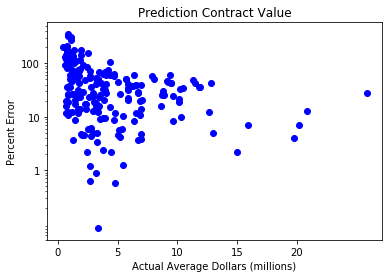

In [38]:
y_test, percent_error, y_pred, _ = predictDollars(gb, position_trimmed, pitcher_trimmed, True)

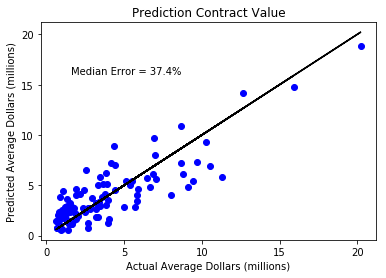

In [39]:
    plt.scatter(y_test, y_pred, color = 'blue')
    plt.plot(y_test, y_test, color = 'k')
    plt.xlabel('Actual Average Dollars (millions)')
    plt.ylabel('Predicted Average Dollars (millions)')
    plt.title('Prediction Contract Value')
    plt.yticks([0,5e6,1e7,1.5e7,2e7],['0','5','10','15','20'])
    plt.xticks([0,5e6,1e7,1.5e7,2e7],['0','5','10','15','20'])
    plt.text(x = 1.6e6, y = 1.6e7, s = "Median Error = {:0.1f}%".format(np.median(percent_error)))
    plt.savefig('./contract_dollars_regression.png')
    plt.show()

In [40]:
all_percent = []
for i in range(1000):
    _, _, _, med_percent = predictDollars(gb, position_trimmed, pitcher_trimmed)
    all_percent.append(med_percent)

In [41]:
np.mean(np.array(all_percent))

31.641689084413258